In [41]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
import sys
import imodels
import imodelsx.process_results
from collections import defaultdict
sys.path.append('../experiments/')
results_dir = '../results/multitask_gam/'

r = imodelsx.process_results.get_results_df(results_dir)
experiment_filename = '../experiments/03_multitask_gam.py'
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
r['r2_test'] = r['r2_test'].clip(-1, 1)
r['r2_gap'] = r['r2_train'] - r['r2_test']
d = r
d = imodelsx.process_results.average_over_seeds(
    d, experiment_filename, key_to_average_over='seed'
)
# r.to_pickle('../results/agg.pkl')
# imodelsx.process_results.delete_runs_in_dataframe(r[(r.use_multitask == 0) * (r.linear_penalty != 'ridge')], actually_delete=True)
# imodelsx.process_results.get_experiment_keys(r, experiment_filename)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 255/255 [00:00<00:00, 1633.65it/s]


In [42]:
d.groupby(['use_multitask', 'interactions', 'linear_penalty']).size()

use_multitask  interactions  linear_penalty
0              0.00          ridge             116
               0.95          ridge              73
1              0.00          ridge              43
               0.95          ridge              23
dtype: int64

### Compare multitask perf

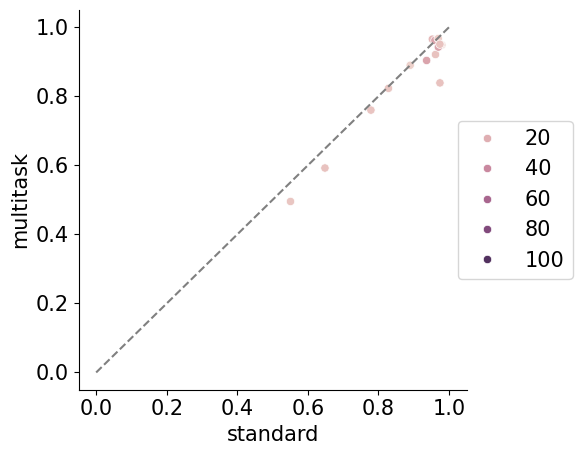

frac_improved 0.04
avg_change -0.03
frac_improved_many_features 0.0
avg_change_many_features nan


In [44]:
# filter datasets for which there is a row with use_multitask=0 and use_multitask=1 (done running)
d2 = d[(d.linear_penalty == 'ridge') * (d.interactions == 0.95)]
d2 = d.groupby(['dataset_name'])
d2 = d2.filter(lambda x: len(x) == 2)

# pivot table for d2 based on dataset_name, use_multitask, and r2_test
r2_table = d2.pivot_table(index=['dataset_name'], columns=[
    'use_multitask'], values='corr_test')

# add num_features based on dataset_name
n_features = d2.groupby(['dataset_name']).first().n_features
n_samples = d2.groupby(['dataset_name']).first().n_samples
r2_table['num_features'] = n_features
r2_table['num_samples'] = n_samples
r2_table['feature_over_samples'] = r2_table['num_features'].astype(
    int) / r2_table['num_samples'].astype(int)
r2_table = r2_table.rename(columns={0: 'standard', 1: 'multitask'})


sns.scatterplot(data=r2_table, x='standard', y='multitask', hue='num_features')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.show()

r2_table['improvement'] = r2_table['multitask'] - r2_table['standard']
print('frac_improved', round((r2_table['improvement'] > 0).mean(), 2))
print('avg_change', r2_table['improvement'].mean().round(2))
many_features = r2_table['num_features'] > 25
if many_features.sum() > 0:
    print('frac_improved_many_features',
          round((r2_table['improvement'][many_features] > 0).mean(), 2))
    print('avg_change_many_features',
          round(r2_table['improvement'][many_features].mean(), 2))
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
# display(r2_table.sort_values('improvement', ascending=False).round(2))

### Compare different linear models

In [ ]:
# filter datasets for which there is a row with use_multitask=0 and use_multitask=1 (done running)
d2 = d
d2 = d.groupby(['dataset_name'])
d2 = d2.filter(lambda x: len(x) == 7)

# pivot table for d2 based on dataset_name, use_multitask, and r2_test
r2_table = d2.pivot_table(index=['dataset_name'], columns=[
    'use_multitask', 'linear_penalty', 'n_boosting_rounds'], values='r2_test').round(2)

# convert multiindex columns to single tuple index
# r2_table.columns = ['_'.join(col).strip()
# for col in r2_table.columns.values]

# add num_features based on dataset_name
# n_features = d2.groupby(['dataset_name']).first().n_features
# n_samples = d2.groupby(['dataset_name']).first().n_samples
# r2_table['num_features'] = n_features
# r2_table['num_samples'] = n_samples
# r2_table['feature_over_samples'] = r2_table['num_features'].astype(
#     int) / r2_table['num_samples'].astype(int)
# r2_table = r2_table.rename(columns={0: 'standard', 1: 'multitask'})


# sns.scatterplot(data=r2_table, x='standard', y='multitask', hue='num_features')
# plt.plot([0, 1], [0, 1], '--', color='gray')
# plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
# plt.show()

# r2_table['improvement'] = r2_table['multitask'] - r2_table['standard']
# print('frac_improved', round(r2_table['improvement'] > 0).mean(), 2)
# print('avg_change', r2_table['improvement'].mean().round(2))
# many_features = r2_table['num_features'] > 25
# print('frac_improved_many_features',
#       round((r2_table['improvement'][many_features] > 0).mean(), 2))
# print('avg_change_many_features',
#       r2_table['improvement'][many_features].mean().round(2))
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(r2_table.sort_values('improvement', ascending=False).round(2))

In [ ]:
r2_table.columns.values

In [ ]:
r2_table